# Generating Airfoils

**Input to define domain**:

- Saved PGA spaces or dataset of 2D shapes (cross sections) with consistent landmarks both in number and reparametrization---i.e., each discrete shape is represented by the same number of landmarks generated by a consistent CST-cosine reparametrization over the shape

- Dependencies detailed below

In [1]:
# Python
import os
import numpy as np
# G2Aero
from g2aero.PGA import PGAspace
from g2aero import SPD
from g2aero import Grassmann as gr
#Plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Read PGA space from saved domain
Reusing the data consistent with the previous notebook [Data-Driven Domain of Shapes](https://g2aero.readthedocs.io/en/latest/how_to_guides/files/0_Data-Driven_Domain.html#), we begin by loading a PGA space from our .npz files saved in `data/pga_space/`.

In [2]:
# load Karcher mean and PGA basis
pga = PGAspace.load_from_file(os.path.join(os.getcwd(), '../../data/pga_space/CST_Gr_PGA.npz'))
print("Grassmann Dataset:")
print(f"Shape of data = {pga.t.shape[0]}-by-{pga.t.shape[1]}")
print(f"Number of shapes = {pga.t.shape[0]}")
print(f"Number of coordinates = {pga.t.shape[1]}")
print('\n')

# load SPD PGA statistics
spd_dict = np.load(os.path.join(os.getcwd(), '../../data/pga_space/CST_SPD_PGA.npz'))
ell = spd_dict['coords']
P0 = spd_dict['karcher_mean']
P = spd_dict['data']
print("SPD Dataset:")
print(f"Shape of data = {P.shape}")
print(f"Number of SPD matrices = {P.shape[0]}")
print(f"Shape of coordinates = {ell.shape}")

Grassmann Dataset:
Shape of data = 13000-by-802
Number of shapes = 13000
Number of coordinates = 802


SPD Dataset:
Shape of data = (13000, 2, 2)
Number of SPD matrices = 13000
Shape of coordinates = (13000, 3)


## Example random shape generation
We outline a simple manual approach to generate new random shapes over the dominate eigenspaces of Grassmann normal coordinate covariance and two choices of avearge scale. However, more sophisticated approaches to sampling are conceivable. As such, we also highlight the use of an automated routine to generate random shapes from a uniform ball of normal coordinates subject to a self-intersection constraint. We demonstrate how shapes with any prescribed coordinates can be replicated using our automated routine by assigning `coef`. We also demonstrate how to generate `n=10` random shapes with full (18) dimensional representations from the same routine.

Note: "warnings" are issued by the automated routine when a shape intersects itself. A new random `coef` is subsequently drawn to replace the corresponding index until the the shape is non-intersecting. This is akin to a crude form of hit-and-run for sampling the rather complicated self-intersections constraint. Future versions of this repository may include more sophisticated approaches to random sampling.

In [3]:
np.random.default_rng(seed=42)
# assign r as the dimension of the PGA shape
r = 8 # should always be less than or equal to 2*(n_landmarks - 2)
pga.t = pga.t[:,:r]

# compute eigenspaces of covariances over Gr(n,2) coordinates
Lambda_t, W_t = np.linalg.eigh(1/np.sqrt(pga.t.shape[0]-1)*( pga.t.T @ pga.t))

# sample a random coordinate with reduce variation to protect against self-intersection
rnd_t = (W_t @ np.diag(Lambda_t)) @ np.random.normal(0,1,size=(r,1))
# rescale this to have 2-norm of `scl' (restrict to ball to avoid intersection)
scl = 0.15
rnd_t = (scl/np.linalg.norm(rnd_t))*rnd_t

# use the random coordinates and intrinsic mean of SPD matrices to sample a random shape
rnd_shape = pga.PGA2shape(rnd_t.flatten(),M=P0,b=pga.b_mean)
# or generate the random shape with an extrinsic-average scale
rnd_shape_avg = pga.PGA2shape(rnd_t.T,M=pga.M_mean,b=pga.b_mean)

# the process of generating a random shape with extrinsic average scale is also automated using:
rnd_shape_auto, _, _ = pga.generate_perturbed_shapes(coef=rnd_t.T,n=1)
# we can also use this routine to generate as many non-intersecting r-dim. shapes as desired by setting `n':
# in this case n=10 samples and we utilize the full-dimension expansion (r=18)
rnd_shapes, rnd_Gr_shapes, rnd_coef = pga.generate_perturbed_shapes(n=10,n_modes=18)
print('\n')
print('Random data:')
print(f'Random shapes shape: {rnd_shapes.shape}')
print(f'Random coord. shape: {rnd_coef.shape}')



Random data:
Random shapes shape: (10, 401, 2)
Random coord. shape: (10, 18)


Then we plot our three randomly generated shapes to compare them visually. The shape generated by our automated routine is given consistent coordinates as the avgerage scale shape, thus those two shapes overlap in the plot. Notice that the extrinsic average scale is slightly "inflated" beyond the intrinsic average.

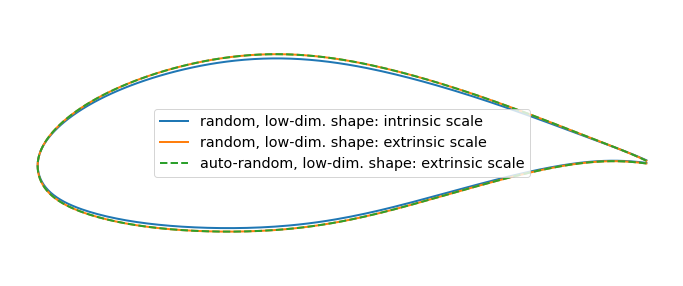

In [4]:
# plot the random shape with different scale
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.plot(rnd_shape[:,0], rnd_shape[:,1],linewidth=2, label='random, low-dim. shape: intrinsic scale')
plt.plot(rnd_shape_avg[:,0], rnd_shape_avg[:,1],linewidth=2, label='random, low-dim. shape: extrinsic scale')
plt.plot(rnd_shape_auto[:,0],rnd_shape_auto[:,1],'--',linewidth=2, label='auto-random, low-dim. shape: extrinsic scale')
# formatting
plt.axis('off')
ax.axis('equal')
ax.legend(fontsize='x-large')

Next, let's plot the first random shape in the set of 10 randomly sampled shapes generated by the automated routine. Additionally, we'll reduce the coordinate expansion for the full-dimensional shapes down to 2, 4, and 8 then overlay the low-dimensional expansions of the shape along consistent reduced coordinates. (lower dimensional planar sections of the Grassmanian) Notice that with increasing dimension we can capture more undulation in the shape and the 8-dimensional shape is nearly visually indistinguishable from the full (18)-dimensional shape while the 2 and 4-dimensional shapes are regularized to have reduced inflection. Visually inspecting the first random shape below, we can observe the regularization achieved with reduced dimensionality. (similar to the results of the previous notebook: [Data-Driven Domain of Shapes](https://g2aero.readthedocs.io/en/latest/how_to_guides/files/0_Data-Driven_Domain.html#)) 

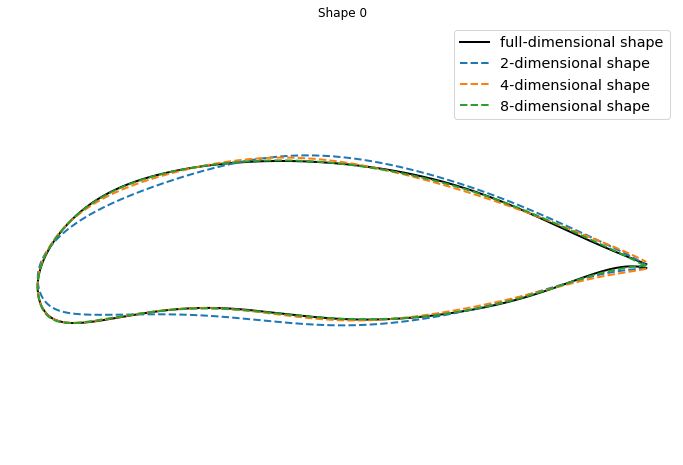

In [5]:
# pick the first random index to closely inspect
rnd_i = 0

dims = [2,4,8]
# plot the random shape with different scale
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.plot(rnd_shapes[rnd_i,:,0], rnd_shapes[rnd_i,:,1],'k',linewidth=2, label='full-dimensional shape')
# loop through low-dimension analouges
for dim in dims:
    shape_low = pga.PGA2shape(rnd_coef[rnd_i,:dim],M=pga.M_mean,b=pga.b_mean)
    plt.plot(shape_low[:,0],shape_low[:,1],'--',linewidth=2,label=str(dim)+"-dimensional shape")
# formatting
ax.set_title(f'Shape {rnd_i}')
plt.axis('off')
ax.axis('equal')
ax.legend(fontsize='x-large')

Let's also plot the full smattering of all 10 of our randomly generated shapes and compare them to consistent low-dimensional analogues. (similar to above) Even with all 10 randomly generated shapes, we draw the same conclusions as above. (reduced dimensionality helps regularize against undulation in the shape) Note, the colors of the curves for all 10 random shapes below are consistent with the legend in the example above.

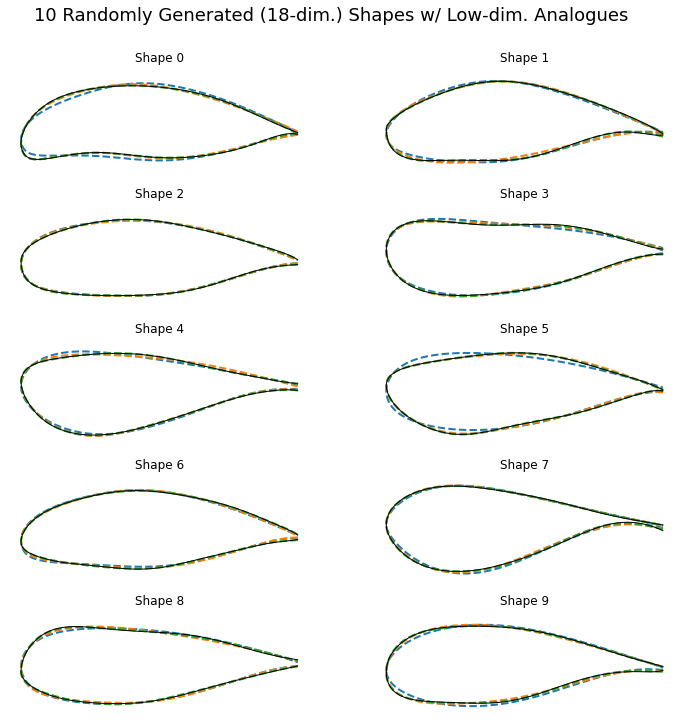

In [6]:
# plot automatically generated random shapes
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.25)
plt.suptitle(f"{10} Randomly Generated ({18}-dim.) Shapes w/ Low-dim. Analogues", fontsize=18, y=0.95)

# loop through the length of shapes
for i, shape in enumerate(rnd_shapes):
    # add a new subplot iteratively
    ax = plt.subplot(5, 2, i + 1)
    
    # loop through low-dimension analouges
    for dim in dims:
        shape_low = pga.PGA2shape(rnd_coef[i,:dim],M=pga.M_mean,b=pga.b_mean)
        plt.plot(shape_low[:,0],shape_low[:,1], \
                 '--',linewidth=2, \
                 label=str(dim)+"-dimensional")
    # plot the random shape
    plt.plot(shape[:,0],shape[:,1],'k',linewidth=1,label="full-dimensional")    

    # chart formatting
    ax.set_title(f'Shape {i}')
    ax.set_xlabel("")
    ax.axis('off')
    ax.axis('equal')

Lastly, let's emphasize the notion of consistency in perturbations. First, we take the two most distinct shapes based on pairwise distances between all 10 randomly generated shapes. Then, we reuse our manually configured perturbation direction from above and utlize the Grassmannian parallel translation utility to perturb disparate shapes in a consistent way.

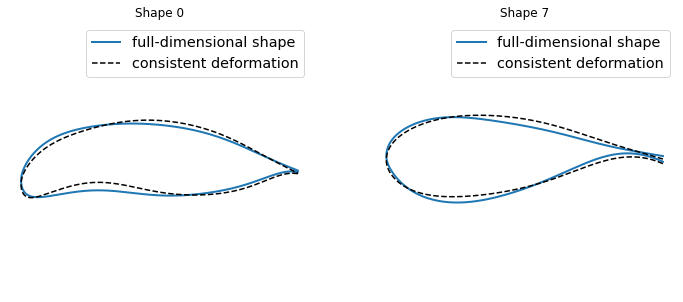

In [7]:
# determine the most different shapes based on the pairwise Grassmannian distance
dist = np.zeros((10,10))
for i in range(10):
    for j in range(i,10):
        # compute unique elements of the pairwise distance matrix
        dist[i,j] = gr.distance(rnd_Gr_shapes[i,:,:], rnd_Gr_shapes[j,:,:])
# determine the largest pair of shapes
i_max = np.unravel_index(np.argmax(dist, axis=None), dist.shape)

# now plot consistent perturbations between the disparate shapes
# take a random direction at the Karcher mean of arbitrary dimension
V0 = (rnd_t.flatten()@pga.Vh[:r]).reshape(-1,2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    # parallel translate the direction to the disparate shapes
    V = gr.parallel_translate(pga.karcher_mean,gr.log(pga.karcher_mean,rnd_Gr_shapes[i_max[i],:,:]),V0)
    # perturb the shapes along the consistent directions at disparate tangent spaces
    P = gr.exp(1,rnd_Gr_shapes[i_max[i],:,:],V)
    # rescale to an appropriate section of the fiber bundle
    P = P @ pga.M_mean + pga.b_mean
    
    # plot results
    ax[i].plot(rnd_shapes[i_max[i],:,0], rnd_shapes[i_max[i],:,1],linewidth=2, label='full-dimensional shape')
    ax[i].plot(P[:,0], P[:,1],'k--',label='consistent deformation')
    # formatting
    ax[i].set_title(f'Shape {i_max[i]}')
    ax[i].axis('off')
    ax[i].axis('equal')
    ax[i].legend(fontsize='x-large')


Notice the visual consistency in the perturbations applied to the two disparate shapes. That is, the perturbations undulate "inward" towards the shape centroid or "outward" away from the shape centroid at consistent landmark arc-length locations. For example, start at any point on the shapes and follow the blue curves around the shapes as though we are tracing the full-dimensional shapes on paper. Notice, as we trace, the black dashed curves deform the shapes consistently inward or outward as we move along the curves, despite the fact that the base shapes are completely different. (not comparable otherwise) Consequently, we can deform distinct shapes in a consistent way to regularize deformations along interpolations of planar shapes defining blades. We ellaborate on this further for the purposes of blade design in [Blade Perturbations](https://g2aero.readthedocs.io/en/latest/how_to_guides/files/3_Blade_perturbation.html#).